# Code Implementation

This code implements **SimPO** algorithm to finetune simple trained LM.

We trained a small transformer model with "TinyShakespeare" dataset. Then we finetune the model with SimPO algorithm so that the finetuned model barely generate the text **containing the same word more than twice**.

So the total algorithm proceeds as follows.

1. Prepare TinyShakespeare dataset and base model.
2. Train the base model with the dataset.
3. Define the reward function to score each text based on the number of repeated words in the text.
4. Using the trained model(reference model), generate the texts and calculate the scores so that we can organnize preference dataset.
5. With the organized preference dataset, finetune the reference model using the SimPO algorithm.

# Setup

In [1]:
import pandas as pd
import math
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Literal, Callable
import random
from tqdm.auto import tqdm
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/논문코드리뷰/논문코드리뷰_DPO SimPO
# Get TinyShakeSpeare dataset
train = pd.read_csv('train.csv')

Mounted at /content/drive
/content/drive/MyDrive/논문코드리뷰/논문코드리뷰_DPO SimPO


# Base Model

In [2]:
@dataclass
class CharTokenizer:
    # Character-level tokenizer
    stoi: Dict[str, int]
    itos: Dict[int, str]
    pad_id: int
    bos_id: int
    eos_id: int

    def encode(self, s: str, add_bos: bool = False, add_eos: bool = False) -> List[int]:
        ids: List[int] = []
        if add_bos:
            ids.append(self.bos_id)
        ids.extend(self.stoi[c] for c in s)
        if add_eos:
            ids.append(self.eos_id)
        return ids

    def decode(self, ids: List[int], skip_special: bool = True) -> str:
        out = []
        for i in ids:
            if skip_special and i in (self.pad_id, self.bos_id, self.eos_id):
                continue
            out.append(self.itos[int(i)])
        return "".join(out)


def build_char_tokenizer_from_text(text: str) -> CharTokenizer:
    specials = ["<PAD>", "<BOS>", "<EOS>"]
    vocab = specials + sorted(set(text))
    stoi = {ch: i for i, ch in enumerate(vocab)}
    itos = {i: ch for ch, i in stoi.items()}
    return CharTokenizer(
        stoi=stoi,
        itos=itos,
        pad_id=stoi["<PAD>"],
        bos_id=stoi["<BOS>"],
        eos_id=stoi["<EOS>"],
    )

class CausalSelfAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dropout: float):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor) -> torch.Tensor:
        B, T, C = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.split(C, dim=-1)

        q = q.view(B, T, self.n_heads, self.d_head).transpose(1, 2)
        k = k.view(B, T, self.n_heads, self.d_head).transpose(1, 2)
        v = v.view(B, T, self.n_heads, self.d_head).transpose(1, 2)

        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.d_head)
        scores = scores.masked_fill(attn_mask == 0, float("-inf"))
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        out = attn @ v
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        out = self.dropout(self.proj(out))
        return out

class TransformerBlock(nn.Module):
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = CausalSelfAttention(d_model, n_heads, dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor) -> torch.Tensor:
        x = x + self.attn(self.ln1(x), attn_mask)
        x = x + self.ff(self.ln2(x))
        return x


class TinyCausalTransformerLM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        max_seq_len: int = 256,
        d_model: int = 256,
        n_layers: int = 6,
        n_heads: int = 8,
        d_ff: int = 1024,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.max_seq_len = max_seq_len

        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_seq_len, d_model)
        self.drop = nn.Dropout(dropout)

        self.blocks = nn.ModuleList(
            [TransformerBlock(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        )
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)

        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m: nn.Module):
        if isinstance(m, (nn.Linear, nn.Embedding)):
            nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.zeros_(m.bias)

    def _causal_mask(self, T: int, device: torch.device) -> torch.Tensor:
        mask = torch.tril(torch.ones((T, T), device=device, dtype=torch.bool))
        return mask.view(1, 1, T, T)

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:
        B, T = input_ids.shape
        if T > self.max_seq_len:
            raise ValueError(f"Sequence length {T} exceeds max_seq_len={self.max_seq_len}")

        pos = torch.arange(T, device=input_ids.device).unsqueeze(0)
        x = self.tok_emb(input_ids) + self.pos_emb(pos)
        x = self.drop(x)

        attn_mask = self._causal_mask(T, input_ids.device)
        for blk in self.blocks:
            x = blk(x, attn_mask)

        x = self.ln_f(x)
        logits = self.head(x)
        return logits

def get_shakespeare_slm(
    text: str,
    max_seq_len: int = 256,
    d_model: int = 256,
    n_layers: int = 6,
    n_heads: int = 8,
    d_ff: int = 1024,
    dropout: float = 0.1,
    seed: int = 42,
    device: Optional[str] = None,
) -> Tuple[TinyCausalTransformerLM, CharTokenizer]:
    # Builds a character tokernizer from the single text and returns a small causal LM

    torch.manual_seed(seed)

    tok = build_char_tokenizer_from_text(text)
    model = TinyCausalTransformerLM(
        vocab_size=len(tok.stoi),
        max_seq_len=max_seq_len,
        d_model=d_model,
        n_layers=n_layers,
        n_heads=n_heads,
        d_ff=d_ff,
        dropout=dropout,
    )

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    return model, tok

In [3]:
# Get the model and the tokenizer
text = train['text'][0]
print(text[:100])
model, tok = get_shakespeare_slm(text, max_seq_len=256, d_model=256, n_layers=6, n_heads=8, d_ff=1024)
print("Vocab size:", len(tok.stoi))
print(model)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You
Vocab size: 68
TinyCausalTransformerLM(
  (tok_emb): Embedding(68, 256)
  (pos_emb): Embedding(256, 256)
  (drop): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): CausalSelfAttention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=1024, out_features=256, bias=True)
        (4): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((256,), eps=1e

# Train

In [4]:
class RandomChunkCharDataset(Dataset):
    # Get the full tokenized text ids as input and returns a random chunk with length block_size.
    def __init__(self, ids: torch.Tensor, block_size: int, num_samples: int, seed: int = 0):
        assert ids.dim() == 1
        assert block_size >= 2
        assert len(ids) > block_size + 1
        self.ids = ids
        self.block_size = block_size
        self.num_samples = num_samples
        self.rng = random.Random(seed)
        self.max_start = len(ids) - (block_size + 1)

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int):
        s = self.rng.randint(0, self.max_start)
        chunk = self.ids[s : s + self.block_size + 1]  # [T+1]
        x = chunk[:-1].clone()  # [T]
        y = chunk[1:].clone()   # [T]
        return x, y

def _collate_fixed(batch):
    x = torch.stack([b[0] for b in batch], dim=0)  # [B,T]
    y = torch.stack([b[1] for b in batch], dim=0)  # [B,T]
    return x, y

def tokenize_text_to_ids(text: str, tok) -> torch.Tensor:
    ids = torch.tensor([tok.stoi[c] for c in text], dtype=torch.long)
    return ids

def split_train_val_ids(ids: torch.Tensor, val_frac: float = 0.1) -> Tuple[torch.Tensor, torch.Tensor]:
    n = len(ids)
    n_val = max(1, int(n * val_frac))
    train_ids = ids[:-n_val]
    val_ids = ids[-n_val:]
    return train_ids, val_ids

@torch.no_grad()
def evaluate_lm(model, loader, device) -> float:
    model.eval()
    total_nll = 0.0
    total_tokens = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)  # [B,T,V]
        B, T, V = logits.shape
        loss = F.cross_entropy(logits.view(B * T, V), y.view(B * T), reduction="sum")

        total_nll += loss.item()
        total_tokens += B * T

    return total_nll / max(1, total_tokens)

def train_char_lm(
    model,
    tok,
    text: str,
    batch_size: int = 64,
    max_seq_len: Optional[int] = None,
    epochs: int = 5,
    lr: float = 3e-4,
    weight_decay: float = 0.01,
    grad_clip: float = 1.0,
    val_frac: float = 0.1,
    steps_per_epoch: int = 2000,
    eval_steps: int = 400,
    seed: int = 0,
    use_amp: bool = True,
    num_workers: int = 0,
):
    device = next(model.parameters()).device
    block_size = max_seq_len if max_seq_len is not None else model.max_seq_len

    # tokenize
    ids = tokenize_text_to_ids(text, tok)

    # split
    train_ids, val_ids = split_train_val_ids(ids, val_frac=val_frac)

    # datasets (random chunks)
    train_ds = RandomChunkCharDataset(
        train_ids, block_size=block_size, num_samples=steps_per_epoch * batch_size, seed=seed
    )
    val_ds = RandomChunkCharDataset(
        val_ids, block_size=block_size, num_samples=eval_steps * batch_size, seed=seed + 999
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=_collate_fixed,
        pin_memory=torch.cuda.is_available(),
        drop_last=True,
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=_collate_fixed,
        pin_memory=torch.cuda.is_available(),
        drop_last=True,
    )

    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    amp_enabled = bool(use_amp and torch.cuda.is_available())
    scaler = torch.amp.GradScaler("cuda", enabled=amp_enabled)

    for ep in range(1, epochs + 1):
        model.train()
        running_nll = 0.0
        running_tokens = 0

        pbar = tqdm(train_loader, desc=f"epoch {ep}/{epochs}", leave=False)
        for x, y in pbar:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            optim.zero_grad(set_to_none=True)

            if amp_enabled:
                with torch.amp.autocast(device_type="cuda", enabled=True):
                    logits = model(x)
                    B, T, V = logits.shape
                    loss = F.cross_entropy(logits.view(B * T, V), y.view(B * T), reduction="mean")
                scaler.scale(loss).backward()
                scaler.unscale_(optim)
                if grad_clip and grad_clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                scaler.step(optim)
                scaler.update()
            else:
                logits = model(x)
                B, T, V = logits.shape
                loss = F.cross_entropy(logits.view(B * T, V), y.view(B * T), reduction="mean")
                loss.backward()
                if grad_clip and grad_clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                optim.step()

            running_nll += loss.item() * (B * T)
            running_tokens += (B * T)

            pbar.set_postfix(loss=running_nll / max(1, running_tokens))

        train_loss = running_nll / max(1, running_tokens)
        val_loss = evaluate_lm(model, val_loader, device=device)

        print(f"[epoch {ep}/{epochs}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

In [5]:
train_char_lm(
    model, tok, text,
    batch_size=64,
    max_seq_len=256,
    epochs=3,
    lr=3e-4,
    steps_per_epoch=2000,
    eval_steps=400,
)

epoch 1/3:   0%|          | 0/2000 [00:00<?, ?it/s]

[epoch 1/3] train_loss=1.7894 | val_loss=1.5130


epoch 2/3:   0%|          | 0/2000 [00:00<?, ?it/s]

[epoch 2/3] train_loss=1.2880 | val_loss=1.4490


epoch 3/3:   0%|          | 0/2000 [00:00<?, ?it/s]

[epoch 3/3] train_loss=1.1501 | val_loss=1.4911


# Generate

In [6]:
@torch.no_grad()
def generate_text(
    model,
    tok,
    prompt: str = "",
    max_new_tokens: int = 400,
    temperature: float = 1.0,
    top_k: Optional[int] = None,
    do_sample: bool = True,
) -> str:
    model.eval()
    device = next(model.parameters()).device

    # Tokenize prompt
    if prompt:
        input_ids = torch.tensor([tok.stoi[c] for c in prompt], dtype=torch.long, device=device).unsqueeze(0)
    else:
        start_char = "\n" if "\n" in tok.stoi else " "
        input_ids = torch.tensor([tok.stoi[start_char]], dtype=torch.long, device=device).unsqueeze(0)

    # Generate token in each timesteps
    for _ in range(max_new_tokens):
        if input_ids.size(1) > model.max_seq_len:
            input_ids = input_ids[:, -model.max_seq_len :]

        logits = model(input_ids)[:, -1, :]  # [1,1,V]
        logits = logits / max(1e-8, temperature)

        if top_k is not None and top_k > 0:
            k = min(top_k, logits.size(-1))
            v, _ = torch.topk(logits, k=k)
            logits = torch.where(logits < v[:, [-1]], torch.full_like(logits, float("-inf")), logits)

        probs = F.softmax(logits, dim=-1)

        if do_sample:
            next_id = torch.multinomial(probs, num_samples=1)  # [1,1]
        else:
            next_id = torch.argmax(probs, dim=-1, keepdim=True)  # [1,1]

        input_ids = torch.cat([input_ids, next_id], dim=1)

    return "".join(tok.itos[int(i)] for i in input_ids.squeeze(0).tolist())

In [7]:
# Generate 500 texts with trained LM.
# This texts are used for organizing preference dataset for finetuning.

generated_text_list = []
for _ in tqdm(range(500)):
    temp = generate_text(model, tok, prompt="ROMEO:\n", max_new_tokens=400, temperature=0.9, top_k=10, do_sample=True)
    generated_text_list.append(temp)

  0%|          | 0/500 [00:00<?, ?it/s]

# Dataset for Finetuning

In [8]:
_WORD_RE = re.compile(r"[A-Za-z']+")

def anti_repetition_score(
    text: str,
    unit: Literal["word", "char_ngram", "word_ngram"] = "word",
    max_repeats: int = 1,
    n: int = 3,
    normalize_case: bool = True,
    ignore_short_words_len_lt: int = 2,
    penalty_power: float = 4.0,
    clamp_top_k: int = 0,
    return_details: bool = False,
) -> float | Tuple[float, dict]:
    """
    This function returns score with the given text. Returned score has the value in [0,1].
    If the text does not have any repeated words, it will get the score 1.
    The more repeated words, the lower the score will be.

    Arguments:
        text (str) : Text to score.
        unit (Literal) : How to partition the text.
        max_repeats (int) : Maximum number of repeats allowed without any penalty.
        n (int) : Number of character or word if the unit is char_ngram or word_ngram.
        normalize_case (bool) : Lower the text or not.
        ignore_short_words_len_lt (int) : If the word is less than this value,
                                        then the repetition of the word is allowed without any penalty.
        penalty_power (float) : Larger penalty power makes the penalty score higher and final score lower.
        clamp_top_k (int) : If > 0, only the top-k most repeated units contribute to the penalty.
        return_details (bool) : Return details or not.

    Returns:
        float : Score.
        dict : Details. (optional)

    """
    # Normalize
    if normalize_case:
        text_proc = text.lower()
    else:
        text_proc = text

    # Check if the value is appropriate
    if max_repeats < 1:
        raise ValueError("max_repeats must be >= 1")
    if unit in ("char_ngram", "word_ngram") and n < 1:
        raise ValueError("n must be >= 1 for n-gram modes")

    # Build units
    if unit == "word":
        words = _WORD_RE.findall(text_proc)
        if ignore_short_words_len_lt > 0:
            words = [w for w in words if len(w) >= ignore_short_words_len_lt]
        units = words

    elif unit == "char_ngram":
        s = text_proc
        units = [s[i:i+n] for i in range(max(0, len(s) - n + 1))]

    elif unit == "word_ngram":
        words = _WORD_RE.findall(text_proc)
        if ignore_short_words_len_lt > 0:
            words = [w for w in words if len(w) >= ignore_short_words_len_lt]
        units = [" ".join(words[i:i+n]) for i in range(max(0, len(words) - n + 1))]
    else:
        raise ValueError("unit must be one of: 'word', 'char_ngram', 'word_ngram'")

    # Return if there is no unit
    total = len(units)
    if total == 0:
        score = 1.0
        details = {"total_units": 0, "penalty": 0.0, "top_repeats": []}
        return (score, details) if return_details else score

    counts = Counter(units)

    # Count excess per unit (beyond max_repeats)
    excess_per_unit = [(u, max(0, c - max_repeats), c) for u, c in counts.items()]
    excess_per_unit.sort(key=lambda t: t[1], reverse=True)

    if clamp_top_k and clamp_top_k > 0:
        excess_per_unit = excess_per_unit[:clamp_top_k]

    # Calculate the penalty
    penalty = 0.0
    for _, ex, _ in excess_per_unit:
        if ex > 0:
            penalty += (ex ** penalty_power)

    # Normalize the penalty by length
    penalty = penalty / total
    score = math.exp(-penalty)

    if return_details:
        top = counts.most_common(10)
        details = {
            "total_units": total,
            "unique_units": len(counts),
            "max_repeats": max_repeats,
            "penalty_power": penalty_power,
            "penalty": penalty,
            "top_repeats": top,
        }
        return score, details

    return score

In [9]:
def build_preference_dataset_from_texts(
    prompts: List[str],
    generated_texts: List[str],
    score_fn: Callable[[str], float],
    n_pairs: int = 5000,
    min_y_chars: int = 120,
    max_y_chars: int = 300,
    min_score_gap: float = 0.10,
    seed: int = 0,
) -> List[Dict[str, str]]:
    """
    This function organizes preference dataset using the reward function and generated texts.

    Arguments:
        prompts (List) : List of input prompts(x).
        generated_texts (List) : List of generated texts(y).
        score_fn (Callable) : Reward function.
        n_pairs (int) : Number of preference pairs to be contained in the preference dataset.
        min_y_chars (int) : Minimum number of characters in y.
        max_y_chars (int) : Maximum number of characters in y.
        min_score_gap (float) : Minimum score gap between two samples.
        seed (int) : Random seed.

    Returns:
        List : List of preference pairs (x,y_w,y_l).
    """
    # Check if the arguments are appropriate
    assert len(prompts) == len(generated_texts)
    assert n_pairs > 0

    rng = random.Random(seed)

    # by_prompt saves the data of the form : {x : [y, score]}
    by_prompt: Dict[str, List[Tuple[str, float]]] = {}

    for x, full in zip(prompts, generated_texts):
        # Strip x if full starts with x
        y = full[len(x):] if full.startswith(x) else full

        # Refine y
        y = y.strip("\n")
        if len(y) < min_y_chars:
            continue
        if len(y) > max_y_chars:
            y = y[:max_y_chars]

        # Compute the score(reward) of y
        s = float(score_fn(y))

        # Update by_prompt
        by_prompt.setdefault(x, []).append((y, s))

    # For each prompt, sort by score and keep as candidates
    for x in list(by_prompt.keys()):
        cands = by_prompt[x]
        if len(cands) < 2:
            del by_prompt[x]
            continue
        cands.sort(key=lambda t: t[1])
        by_prompt[x] = cands

    if not by_prompt:
        raise ValueError("No prompts have >=2 usable candidates after filtering. "
                         "Try lowering min_y_chars or max_y_chars, or provide more samples.")

    prompt_keys = list(by_prompt.keys())

    pref_data: List[Dict[str, str]] = []

    # Sample a winner/loser from one prompt with a minimum score gap
    def sample_pair_for_prompt(x: str) -> Optional[Dict[str, str]]:
        cands = by_prompt[x]
        for _ in range(12):
            i, j = rng.sample(range(len(cands)), 2)
            (y1, s1), (y2, s2) = cands[i], cands[j]
            if abs(s1 - s2) >= min_score_gap:
                if s1 > s2:
                    return {"x": x, "y_w": y1, "y_l": y2}
                else:
                    return {"x": x, "y_w": y2, "y_l": y1}

        (y_low, s_low) = cands[0]
        (y_high, s_high) = cands[-1]
        if (s_high - s_low) >= min_score_gap:
            return {"x": x, "y_w": y_high, "y_l": y_low}

        return None

    # Build dataset
    max_trials = n_pairs * 10
    trials = 0
    while len(pref_data) < n_pairs and trials < max_trials:
        trials += 1
        x = rng.choice(prompt_keys)
        pair = sample_pair_for_prompt(x)
        if pair is None:
            continue
        if pair["y_w"] == pair["y_l"]:
            continue

        pref_data.append(pair)

    if len(pref_data) < n_pairs:
        print(f"[WARN] Only built {len(pref_data)} / {n_pairs} pairs. "
              f"Try lowering min_score_gap (currently {min_score_gap}) or relaxing length filters.")

    return pref_data

In [10]:
prompts = ["ROMEO:\n"] * 500
pref_data = build_preference_dataset_from_texts(
    prompts, generated_text_list,
    score_fn=anti_repetition_score,
    n_pairs=3000,
    min_y_chars=120,
    max_y_chars=280,
    min_score_gap=0.12,
    seed=0,
)
print(len(pref_data))
print(pref_data[0].keys())
print(pref_data[0]["x"][:100])

3000
dict_keys(['x', 'y_w', 'y_l'])
ROMEO:



# SimPO

In [11]:
class CharPreferenceDataset(Dataset):
    # Get pref_data of the form [{x, y_w, y_l}]
    # Returns {w_ids, w_mask, l_ids, l_mask}
    def __init__(
        self,
        pref_data: List[Dict[str, str]],
        tok,
        max_seq_len: int,
        add_eos_to_y: bool = False,
    ):
        self.data = pref_data
        self.tok = tok
        self.max_seq_len = max_seq_len
        self.add_eos_to_y = add_eos_to_y

        # Indices of valid data in pref_data are stored in valid_idx
        self.valid_idx = []
        for i, ex in enumerate(self.data):
            x, yw, yl = ex["x"], ex["y_w"], ex["y_l"]
            if all(c in tok.stoi for c in x) and all(c in tok.stoi for c in yw) and all(c in tok.stoi for c in yl):
                self.valid_idx.append(i)

        if len(self.valid_idx) == 0:
            raise ValueError("No valid examples: found OOV characters w.r.t. tokenizer vocab.")

    def __len__(self) -> int:
        return len(self.valid_idx)

    def _encode_xy(self, x: str, y: str) -> Tuple[torch.Tensor, torch.Tensor]:
        # Encode x+y as raw stream
        x_ids = [self.tok.stoi[c] for c in x]
        y_ids = [self.tok.stoi[c] for c in y]
        if self.add_eos_to_y:
            y_ids = y_ids + [self.tok.eos_id]

        ids = x_ids + y_ids
        y_start = len(x_ids)
        y_mask = [0] * y_start + [1] * (len(ids) - y_start)

        # Truncate from the left so we preserve the end of y if too long
        if len(ids) > self.max_seq_len:
            overflow = len(ids) - self.max_seq_len
            ids = ids[overflow:]
            y_mask = y_mask[overflow:]

        return torch.tensor(ids, dtype=torch.long), torch.tensor(y_mask, dtype=torch.float32)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        # Returns ids, mask of x+y
        ex = self.data[self.valid_idx[idx]]
        x, yw, yl = ex["x"], ex["y_w"], ex["y_l"]
        w_ids, w_mask = self._encode_xy(x, yw)
        l_ids, l_mask = self._encode_xy(x, yl)
        return {"w_ids": w_ids, "w_mask": w_mask, "l_ids": l_ids, "l_mask": l_mask}

def collate_char_pref(batch: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    # Batch collator. Merge the dictionaries and add attention mask.
    B = len(batch)
    w_max = max(b["w_ids"].size(0) for b in batch)
    l_max = max(b["l_ids"].size(0) for b in batch)

    w_ids = torch.full((B, w_max), 0, dtype=torch.long)
    w_mask = torch.zeros((B, w_max), dtype=torch.float32)
    w_attn = torch.zeros((B, w_max), dtype=torch.float32)

    l_ids = torch.full((B, l_max), 0, dtype=torch.long)
    l_mask = torch.zeros((B, l_max), dtype=torch.float32)
    l_attn = torch.zeros((B, l_max), dtype=torch.float32)

    for i, b in enumerate(batch):
        wl = b["w_ids"].size(0)
        ll = b["l_ids"].size(0)
        w_ids[i, :wl] = b["w_ids"]
        w_mask[i, :wl] = b["w_mask"]
        w_attn[i, :wl] = 1.0
        l_ids[i, :ll] = b["l_ids"]
        l_mask[i, :ll] = b["l_mask"]
        l_attn[i, :ll] = 1.0

    return {
        "w_ids": w_ids, "w_mask": w_mask, "w_attn": w_attn,
        "l_ids": l_ids, "l_mask": l_mask, "l_attn": l_attn,
    }

def avg_logp_y_region(
    model,
    input_ids: torch.Tensor,
    y_mask: torch.Tensor,
    attn_mask: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Compute average log likelihood of the predicted y tokens.
    Average log likelihood : 1/|y| * log pi_theta(y|x)
    This function is used in SimPO objective.

    Arguments:
        model (nn.Module) : Language model.
        input_ids (torch.Tensor) : [B,T]
        y_mask (torch.Tensor) : [B,T]
        attn_mask (torch.Tensor) : [B,T]

    Returns:
        avg_logp (torch.Tensor) : [B] average log p(y|x) over predicted y tokens
        y_len (torch.Tensor) : [B] number of predicted y tokens used
    """
    logits = model(input_ids) # [B,T,V]
    logp = F.log_softmax(logits, dim=-1) # [B,T,V]

    targets = input_ids[:, 1:] # [B,T-1]
    tok_logp = logp[:, :-1].gather(-1, targets.unsqueeze(-1)).squeeze(-1) # [B,T-1]

    mask = (y_mask[:, 1:] * attn_mask[:, 1:]) # [B,T-1]
    y_len = mask.sum(dim=-1).clamp_min(1.0) # [B]
    avg_logp = (tok_logp * mask).sum(dim=-1) / y_len # [B]
    return avg_logp, y_len

def finetune_simpo_char_lm(
    model,
    tok,
    pref_data: List[Dict[str, str]],
    max_seq_len: Optional[int] = None,
    add_eos_to_y: bool = False,
    batch_size: int = 64,
    epochs: int = 3,
    lr: float = 1e-4,
    weight_decay: float = 0.01,
    grad_clip: float = 1.0,
    beta: float = 10.0,
    gamma: float = 0.5,
    val_split: float = 0.05,
    seed: int = 0,
    use_amp: bool = True,
    num_workers: int = 0,
) -> None:
    """
    Finetunes the model with SimPO objective.
    SimPO objective:
        margin = beta * avg_logp(y_w|x) - beta * avg_logp(y_l|x) - gamma
        loss = -logsigmoid(margin)

    Arguments:
        model (nn.Module) : Language model.
        tok (Class) : Tokenizer.
        pref_data (List) : List of preference pairs (x,y_w,y_l).
        max_seq_len (int) : Maximum sequence length of the train data.
        add_eos_to_y (bool) : Add end of sequence token to y.
        batch_size (int) : Batch size.
        epochs (int) : Number of epochs.
        lr (float) : Learning rate.
        weight_decay (float) : Weight decay.
        grad_clip (float) : Gradient clipping.
        beta (float) : Beta parameter in SimPO objective.
        gamma (float) : Gamma parameter in SimPO objective.
        val_split (float) : Validation split.
        seed (int) : Random seed.
        use_amp (bool) : Use automatic mixed precision.
        num_workers (int) : Number of workers for data loading.
    """
    random.seed(seed)
    torch.manual_seed(seed)
    device = next(model.parameters()).device

    if max_seq_len is None:
        max_seq_len = model.max_seq_len

    # Split preference data
    idxs = list(range(len(pref_data)))
    random.shuffle(idxs)
    n_val = max(1, int(len(idxs) * val_split))
    val_idxs = idxs[:n_val]
    tr_idxs = idxs[n_val:]

    # Get train dataset
    train_list = [pref_data[i] for i in tr_idxs]
    val_list = [pref_data[i] for i in val_idxs]

    train_ds = CharPreferenceDataset(train_list, tok, max_seq_len=max_seq_len, add_eos_to_y=add_eos_to_y)
    val_ds = CharPreferenceDataset(val_list, tok, max_seq_len=max_seq_len, add_eos_to_y=add_eos_to_y)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_char_pref,
        pin_memory=torch.cuda.is_available(),
        drop_last=False,
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_char_pref,
        pin_memory=torch.cuda.is_available(),
        drop_last=False,
    )

    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    amp_enabled = bool(use_amp and torch.cuda.is_available())
    scaler = torch.amp.GradScaler("cuda", enabled=amp_enabled)

    @torch.no_grad()
    def eval_val() -> Tuple[float, float]:
        # Returns loss and win rate of eval dataset
        # "Win" means beta * avg_logp of w > beta * avg_logp of l + gamma
        # which is equal to reward of w > reward of l + gamma
        model.eval()
        tot_loss = 0.0
        tot_n = 0
        tot_win = 0
        for batch in val_loader:
            w_ids = batch["w_ids"].to(device)
            w_mask = batch["w_mask"].to(device)
            w_attn = batch["w_attn"].to(device)

            l_ids = batch["l_ids"].to(device)
            l_mask = batch["l_mask"].to(device)
            l_attn = batch["l_attn"].to(device)

            w_avg, _ = avg_logp_y_region(model, w_ids, w_mask, w_attn)
            l_avg, _ = avg_logp_y_region(model, l_ids, l_mask, l_attn)

            margin = beta * w_avg - beta * l_avg - gamma
            loss = -F.logsigmoid(margin).mean()

            tot_loss += loss.item() * w_ids.size(0)
            tot_win += (margin > 0).sum().item()
            tot_n += w_ids.size(0)
        return tot_loss / max(1, tot_n), tot_win / max(1, tot_n)

    # Train
    for ep in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        seen = 0

        pbar = tqdm(train_loader, desc=f"SimPO ep {ep}/{epochs}")
        for batch in pbar:
            w_ids = batch["w_ids"].to(device)
            w_mask = batch["w_mask"].to(device)
            w_attn = batch["w_attn"].to(device)

            l_ids = batch["l_ids"].to(device)
            l_mask = batch["l_mask"].to(device)
            l_attn = batch["l_attn"].to(device)

            optim.zero_grad(set_to_none=True)

            if amp_enabled:
                with torch.amp.autocast(device_type="cuda", enabled=True):
                    w_avg, _ = avg_logp_y_region(model, w_ids, w_mask, w_attn)
                    l_avg, _ = avg_logp_y_region(model, l_ids, l_mask, l_attn)
                    margin = beta * w_avg - beta * l_avg - gamma
                    loss = -F.logsigmoid(margin).mean()

                scaler.scale(loss).backward()
                scaler.unscale_(optim)
                if grad_clip and grad_clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                scaler.step(optim)
                scaler.update()
            else:
                w_avg, _ = avg_logp_y_region(model, w_ids, w_mask, w_attn)
                l_avg, _ = avg_logp_y_region(model, l_ids, l_mask, l_attn)
                margin = beta * w_avg - beta * l_avg - gamma
                loss = -F.logsigmoid(margin).mean()

                loss.backward()
                if grad_clip and grad_clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                optim.step()

            running_loss += loss.item() * w_ids.size(0)
            seen += w_ids.size(0)
            pbar.set_postfix(loss=running_loss / max(1, seen))

        train_loss = running_loss / max(1, seen)
        val_loss, val_winrate = eval_val()
        print(f"[SimPO ep {ep}/{epochs}] train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  val_winrate={val_winrate:.3f}")

In [12]:
finetune_simpo_char_lm(
    model, tok, pref_data,
    max_seq_len=256,
    batch_size=64,
    epochs=3,
    lr=1e-4,
    beta=10.0,
    gamma=0.5,
)

SimPO ep 1/3:   0%|          | 0/45 [00:00<?, ?it/s]

[SimPO ep 1/3] train_loss=0.6458  val_loss=0.2486  val_winrate=0.893


SimPO ep 2/3:   0%|          | 0/45 [00:00<?, ?it/s]

[SimPO ep 2/3] train_loss=0.1842  val_loss=0.1183  val_winrate=0.953


SimPO ep 3/3:   0%|          | 0/45 [00:00<?, ?it/s]

[SimPO ep 3/3] train_loss=0.1063  val_loss=0.0755  val_winrate=0.953


# Results

  0%|          | 0/50 [00:00<?, ?it/s]

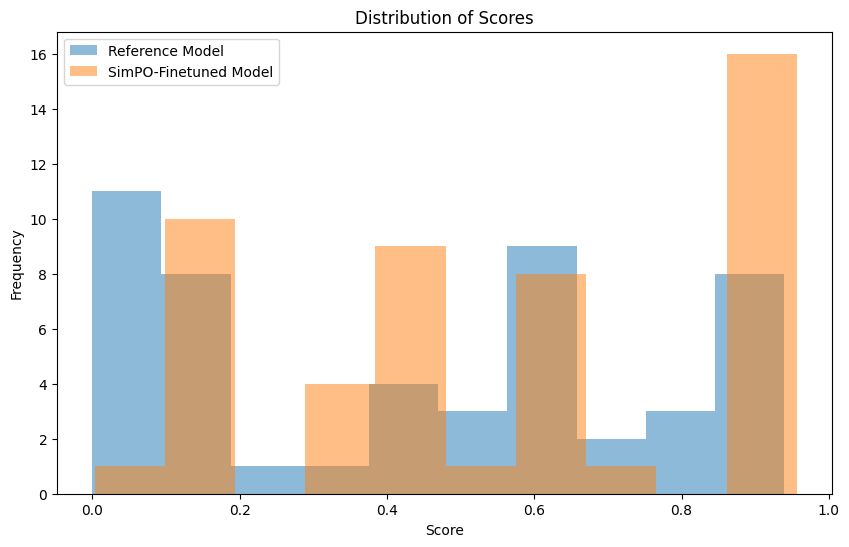

In [15]:
# Number of texts to evalulate the result
n = 50

# We already have list of texts generated with reference model
ref_texts = generated_text_list[:n]

# List of texts generated with SimPO-finetuned model
simpo_texts = []
for _ in tqdm(range(n)):
    temp = generate_text(model, tok, prompt="ROMEO:\n", max_new_tokens=400, temperature=0.9, top_k=10, do_sample=True)
    simpo_texts.append(temp)

# Compare the score
ref_scores = [anti_repetition_score(text) for text in ref_texts]
simpo_scores = [anti_repetition_score(text) for text in simpo_texts]

plt.figure(figsize=(10, 6))
plt.hist(ref_scores, bins=10, alpha=0.5, label='Reference Model')
plt.hist(simpo_scores, bins=10, alpha=0.5, label='SimPO-Finetuned Model')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')
plt.legend()
plt.show()

In [21]:
# Check if the generated text is not abnormal
print("Reference model genrates:")
print(generated_text_list[1])
print("-"*50)
print("SimPO-finetuned model genrates:")
print(simpo_texts[1])

Reference model genrates:
y be; 'tis some mock spirit of accuses.

MENENIUS:
You have made themselves. I, sir, good Capitol,
Who, good man consent years, still on, have you lived
By mother, which way to call your chance
A worthy gods, how with the great curboard!

SICINIUS:
Then, we
--------------------------------------------------
SimPO-finetuned model genrates:

Where is not redemen, that live's be inter
Both des our dout. Cour termorse,
Our elsse,
What.
Gosss fees erever:
What, wilt thoughts be must besing were
This, being our absence.
Touch. Whow fas is somethink'd at bethinks
Like thanks? whose were come so.
Wh
